## Table of Contents

1. ) [Introduction](#Overview)
    * [Problem Statement](#Problem-Statement)
    * [Data Background](#Data-Background)
    * [Data Cleaning](#Data-Cleaning)
2. ) [Analysis](#Analysis)
    * [Data Exploration](#Data-Exploration)
    * [Industry Methods](#Industry)
        * [Five Thirty Eight ELO](#Five-Thirty-Eight-ELO)    
    * [Colloqiual](#Colloquial)
        * [Seed Selection](#Seed-Selection)
4. ) [Results](#Results)
5. ) [Conclusions](#Conclusions)
    * [Next Steps](#Next-Steps)

# Introduction

## Problem Statement

March Madness is one of the most popular offseasons in college sports. Many people heavily rely upon seed to select their winners in March Madness. In this notebook, the dataset will be explored for interesting historical revelations.

## Data Background

We are just focusing on comparing teams and assigning status as underdog based on seed. This is to cover the potential error that might arise from trying to assign every team a ranking discrete overall ranking.
Thus when same seed teams play we discard this as of interest for the analysis

Data was obtained from ... Data Set

This data only spans 1985, the beginning of current era March Madness, to 2016. 
In future revisions this data will be manually scraped to stay up to date

**Notes**: 
* Seed is inversely related to good teams 
    * higher seed is lower ranking
    * 1 seed is the best seed

### Importing 

In [1]:
### Basic Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

### ignore warnings
import warnings 
warnings.filterwarnings("ignore")

In [2]:
### renamed CSV from "NCAA Mens March Madness Historical Results.csv" to "March_Madness_Games.csv"
mm_df= pd.read_csv("March_Madness_Games.csv")
mm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           2050 non-null   object
 1   Round          2050 non-null   object
 2   Region         2038 non-null   object
 3   Winning Seed   2050 non-null   int64 
 4   Winner         2050 non-null   object
 5   Winning Score  2050 non-null   int64 
 6   Losing Seed    2050 non-null   int64 
 7   Loser          2050 non-null   object
 8   Losing Score   2050 non-null   int64 
 9   Overtime       130 non-null    object
dtypes: int64(4), object(6)
memory usage: 160.3+ KB


In [3]:
mm_df.head() #print first 5 lines

,Date,Round,Region,Winning Seed,Winner,Winning Score,Losing Seed,Loser,Losing Score,Overtime
0,3/14/85,Round of 64,East,1,Georgetown,68,16,Lehigh,43,NaN
1,3/14/85,Round of 64,East,4,"Loyola, Illinois",59,13,Iona,58,NaN
2,3/14/85,Round of 64,East,5,Southern Methodist,85,12,Old Dominion,68,NaN
3,3/14/85,Round of 64,East,8,Temple,60,9,Virginia Tech,57,NaN
4,3/14/85,Round of 64,Midwest,1,Oklahoma,96,16,North Carolina A&T,83,NaN


## Data Cleaning

In [4]:
#Testing (save for .py version)
# date_time_str= (mm_df["Date"][0])
# date_time_obj = datetime.strptime(date_time_str, '%m/%d/%y')
# date_time_str

#Convert String to DateTime Object
mm_df["Date"]= pd.to_datetime(mm_df['Date'], format='%m/%d/%y').dt.date

In [5]:
#Create Year Variable
mm_df['Year'] = pd.DatetimeIndex(mm_df['Date']).year 

#Create Total Points per game (not including OT) Variable
mm_df["Total Score"]= mm_df["Winning Score"]+ mm_df["Losing Score"]

###Detect Cases where underdog wins (Save for .py version)
# mm_df["Underdog Wins"]= mm_df["Winning Seed"] < 

###Exclude all play in games (11, 12, 16, in Opening Round)
###PLAY IN GAMES ONLY STARTED IN 2001
not_playin_game= mm_df["Round"] != "Opening Round"

#Create Variable Underdog
# detect when lower seed wins; when same seed ignore (or later could look up ranking of that year and pick based on higher team ranked)
total_games= len(mm_df)
# mm_df[mm_df["Winning Seed"] > mm_df["Losing Seed"]]
mm_df["Underdog"]= mm_df["Winning Seed"] > mm_df["Losing Seed"]


In [6]:
#Create Seed Differential Variable to express the number of seeds between losing and winning teams. A negative represents a lower seeded team
#total difference in seeds between teams
mm_df["Seed Differential"]= mm_df["Winning Seed"]- mm_df["Losing Seed"]
# mm_df[mm_df["Seed Differential"]==]
#mm_df.loc[(mm_df['Winning Seed'] == 1) & (mm_df['Losing Seed'] == 1)]


In [7]:
#remove same seed games (number of same seed games)
mm_df[mm_df["Winning Seed"]== mm_df["Losing Seed"]]
#temporarily remove same Seed games
diff_seed= mm_df["Winning Seed"]!= mm_df["Losing Seed"]
mm_df= mm_df[diff_seed]


#Testing (Save for .py version later)
#CHECK LEN IS DIFFERENT
# print(len(mm_df[not_playin_game]) != len(mm_df))
# mm_df= mm_df[not_playin_game] # len(mm_df)
#check that all have been removed
# check= mm_df["Round"] == "Opening Round"
# mm_df[check]

## Data Exploration

### Completed Dataset

## Variable Examination

In [8]:
#Listing Final Variables
col_name = mm_df.columns.values.tolist()
col_name

['Date',
 'Round',
 'Region',
 'Winning Seed',
 'Winner',
 'Winning Score',
 'Losing Seed',
 'Loser',
 'Losing Score',
 'Overtime',
 'Year',
 'Total Score',
 'Underdog',
 'Seed Differential']

*** Underdog is the most important variable we have to focus on. This is true when the lower seed team has won and false when not. We have already removed all same seed games from out dataset

# Analysis

In [9]:
#Percentage of lower seed/ underdog winning
underdog_wins= len(mm_df[mm_df["Winning Seed"] > mm_df["Losing Seed"]])
underdog_pct= underdog_wins/ total_games
favorited_wins= total_games- underdog_wins
favorited_wins/len(mm_df)

0.7464859437751004

Among games involving different seeded teams, the higher seed team has won 74% of the time

## Data Exploration

In [10]:
underdog_df= mm_df[mm_df["Underdog"]== True]
underdog_df

# underdog_df[underdog_df["Seed Differential"]]
underdog_df["Seed Differential"].value_counts()
underdog_df["Seed Differential"].describe()
pre_list= list(underdog_df["Seed Differential"])

category_dict= {}

for diff in pre_list:
    cat_val= None
    if diff<4:
        cat_val= "1-3 Seed Difference"
    elif diff>3 and diff<7:
        cat_val= "4-6 Seed Difference"
    elif diff>6 and diff<10:
        cat_val= "7-9 Seed Difference"
    elif diff>9:
        cat_val= "10-13 Seed Difference"

    if not cat_val in category_dict:
        category_dict[cat_val]= 0
    category_dict[cat_val]+= 1
    
stor_val= sum(category_dict.values())
category_dict= {k:v/(stor_val) for (k,v) in category_dict.items()}
(category_dict)

# category_dict= {}
# for val in category_list:
    
#<1-3; 4-6,7-9; 10-13

# underdog_df["Seed Differential"].value_counts()
# mm_df[mm_df["Seed Differential"]== 13]

{'1-3 Seed Difference': 0.4920071047957371,
 '4-6 Seed Difference': 0.19005328596802842,
 '7-9 Seed Difference': 0.261101243339254,
 '10-13 Seed Difference': 0.056838365896980464}

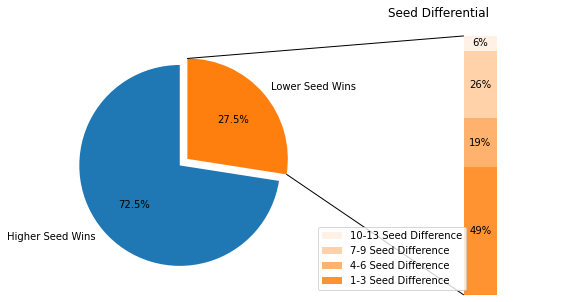

In [11]:
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters

overall_ratios = sizes = [favorited_wins, underdog_wins]
labels = "Higher Seed Wins", "Lower Seed Wins"
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -90 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
### Seed of the underdog


# underdog
# divide the seed differential from the total

age_ratios = category_dict.values()
age_labels =  category_dict.keys()
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C1', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Seed Differential')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 5 * width, 2.5 * width)

###DRAWING LINES

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()


In this plot, the conjoined chart (right) represents the difference among lower seed teams

# Lowest Seed teams to win; (clarify 2022)

In [12]:
largest_upset= underdog_df["Seed Differential"].max()
underdog_df[mm_df["Seed Differential"]== largest_upset]

,Date,Round,Region,Winning Seed,Winner,Winning Score,Losing Seed,Loser,Losing Score,Overtime,Year,Total Score,Underdog,Seed Differential
381,1991-03-14,Round of 64,East,15,Richmond,73,2,Syracuse,69,NaN,1991,142,True,13
519,1993-03-18,Round of 64,West,15,Santa Clara,64,2,Arizona,61,NaN,1993,125,True,13
775,1997-03-14,Round of 64,East,15,Coppin State,78,2,South Carolina,65,NaN,1997,143,True,13
1024,2001-03-15,Round of 64,West,15,Hampton,58,2,Iowa State,57,NaN,2001,115,True,13
1746,2012-03-16,Round of 64,South,15,Lehigh,75,2,Duke,70,NaN,2012,145,True,13
1750,2012-03-16,Round of 64,West,15,Norfolk State,86,2,Missouri,84,NaN,2012,170,True,13
1813,2013-03-22,Round of 64,South,15,Florida Gulf Coast,78,2,Georgetown,68,NaN,2013,146,True,13
2008,2016-03-18,Round of 64,Midwest,15,Middle Tennessee State,90,2,Michigan State,81,NaN,2016,171,True,13


*As of 2018, there is 1 16-seed team win in March Madness, UMBC.

In [13]:
#Plotting
# total underdog win ratio per season
# total underdog per round
# among the top 4 seeds which is most likely to lose?



# ratio of their appearances
underdog_frame= mm_df[["Winner", "Underdog"]].groupby("Winner").sum().sort_values(["Underdog"], ascending= False).head(10)

test= underdog_frame["Underdog"]
input_val= dict(test)

underdog_frame


,Underdog
Winner,
Villanova,15
Michigan State,14
Syracuse,11
Butler,10
Gonzaga,10
Connecticut,10
Arizona,10
Temple,10
"Xavier, Ohio",9


# Teams with the Most Underdog Wins

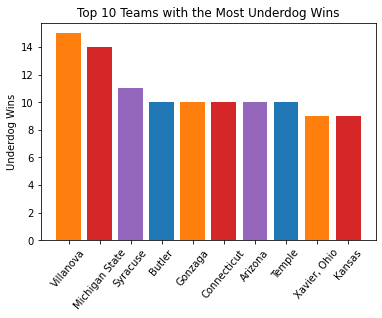

In [25]:
# Bar chart and then show years too
# Show the seeds they've won as underdogs

fig, ax = plt.subplots()

teams = input_val.keys()
counts = input_val.values()
bar_colors = ['tab:orange', 'tab:red', "tab:purple", 'tab:blue']

ax.bar(teams, counts,  color=bar_colors)

ax.set_ylabel('Underdog Wins')
ax.set_title('Top 10 Teams with the Most Underdog Wins')
ax.tick_params(axis='x', rotation=50)

# ax.legend(title='Fruit color')

plt.show()


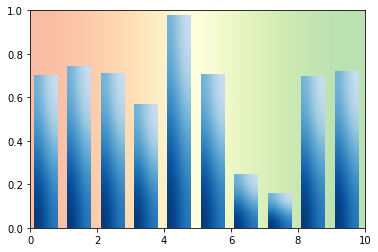

In [15]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)


def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):
    """
    Draw a gradient image based on a colormap.

    Parameters
    ----------
    ax : Axes
        The axes to draw on.
    extent
        The extent of the image as (xmin, xmax, ymin, ymax).
        By default, this is in Axes coordinates but may be
        changed using the *transform* keyword argument.
    direction : float
        The direction of the gradient. This is a number in
        range 0 (=vertical) to 1 (=horizontal).
    cmap_range : float, float
        The fraction (cmin, cmax) of the colormap that should be
        used for the gradient, where the complete colormap is (0, 1).
    **kwargs
        Other parameters are passed on to `.Axes.imshow()`.
        In particular useful is *cmap*.
    """
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im


def gradient_bar(ax, x, y, width=0.5, bottom=0):
    for left, top in zip(x, y):
        right = left + width
        gradient_image(ax, extent=(left, right, bottom, top),
                       cmap=plt.cm.Blues_r, cmap_range=(0, 0.8))


xmin, xmax = xlim = 0, 10
ymin, ymax = ylim = 0, 1

fig, ax = plt.subplots()
ax.set(xlim=xlim, ylim=ylim, autoscale_on=False)

# background image
gradient_image(ax, direction=1, extent=(0, 1, 0, 1), transform=ax.transAxes,
               cmap=plt.cm.RdYlGn, cmap_range=(0.2, 0.8), alpha=0.5)

N = 10
x = np.arange(N) + 0.1
y = np.random.rand(N)
gradient_bar(ax, x, y, width=0.7)
ax.set_aspect('auto')
plt.show()

# Dates

In [16]:
# mm_df[mm_df["Winning Seed"]== 16]
mm_df["Date"]

0       1985-03-14
1       1985-03-14
2       1985-03-14
3       1985-03-14
4       1985-03-14
           ...    
2044    2016-03-26
2045    2016-03-27
2046    2016-03-27
2047    2016-04-02
2049    2016-04-04
Name: Date, Length: 1992, dtype: object

## then Gather data on the team (timeline

In [17]:
year_frame= mm_df[["Date", "Region", "Underdog"]] #farthest underdogs per year

underdog_frame= mm_df[["Winner", "Underdog"]].groupby("Winner").sum().sort_values(["Underdog"], ascending= False).head(10)
underdog_frame

,Underdog
Winner,
Villanova,15
Michigan State,14
Syracuse,11
Butler,10
Gonzaga,10
Connecticut,10
Arizona,10
Temple,10
"Xavier, Ohio",9


# Most Successful Underdogs

In [18]:
#display teams in order of round

temp= mm_df.loc[(mm_df['Underdog'] == True) & (mm_df['Round'] == "National Championship")]
temp.sort_values("Winning Seed", ascending= False)

,Date,Round,Region,Winning Seed,Winner,Winning Score,Losing Seed,Loser,Losing Score,Overtime,Year,Total Score,Underdog,Seed Differential
62,1985-04-01,National Championship,National Championship,8,Villanova,66,1,Georgetown,64,NaN,1985,130,True,7
251,1988-04-04,National Championship,National Championship,6,Kansas,83,1,Oklahoma,79,NaN,1988,162,True,5
818,1997-03-31,National Championship,National Championship,4,Arizona,84,1,Kentucky,79,1 OT,1997,163,True,3
1199,2003-04-07,National Championship,National Championship,3,Syracuse,81,2,Kansas,78,NaN,2003,159,True,1
1391,2006-04-03,National Championship,National Championship,3,Florida,73,2,UCLA,57,NaN,2006,130,True,1
125,1986-03-31,National Championship,National Championship,2,Louisville,72,1,Duke,69,NaN,1986,141,True,1
2049,2016-04-04,National Championship,NaN,2,Villanova,77,1,North Carolina,74,NaN,2016,151,True,1


Many of the underdogs here are trivial, as it was only a difference of 1 seed. 
However, Villanova is the lowest underdog seed to ever win a national championship and they were also the first team in the modern era of March Madness to win.

# Conclusions

While the underdog is more likely to lose in general, there is undeniably a high enough presence of "Underdogs" winning to warrant excitement.

## Next Steps

* Add more depth to the Underdog Criteria
    * Look at how teams in different Regions are ranked against each other in overall rankings to decide when a team is an underdog even though both teams are the same seeds across different regions
* Further Explore underdog teams
Evaluate more fine-grained variables about the teams and analyze that 